In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Silnik ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import cross_validate
import xgboost as xgb
from hyperopt import hp
from hyperopt import fmin, tpe
from hyperopt.pyll.base import scope

In [6]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [7]:
from sklearn.feature_selection import RFE

In [8]:
data = pd.read_csv('training_sample.csv')

In [9]:
data.shape

(455401, 25)

In [10]:
data_to_join = pd.read_csv('testing_sample.csv')

In [11]:
data_to_join.shape

(151655, 25)

In [12]:
data = pd.concat([data, data_to_join], ignore_index=True)

In [13]:
data.shape

(607056, 25)

In [14]:
data.columns

Index(['UserID', 'basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'sort_by', 'image_picker', 'account_page_click', 'promo_banner_click',
       'detail_wishlist_add', 'list_size_dropdown', 'closed_minibasket_click',
       'checked_delivery_detail', 'checked_returns_detail', 'sign_in',
       'saw_checkout', 'saw_sizecharts', 'saw_delivery', 'saw_account_upgrade',
       'saw_homepage', 'device_mobile', 'device_computer', 'device_tablet',
       'returning_user', 'loc_uk', 'ordered'],
      dtype='object')

In [15]:
selected_features = ['basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'list_size_dropdown', 'saw_homepage', 'device_mobile', 'returning_user', 'ordered']

In [16]:
data = data[selected_features]

In [17]:
data

,basket_icon_click,basket_add_list,basket_add_detail,list_size_dropdown,saw_homepage,device_mobile,returning_user,ordered
0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,1,0
3,0,0,0,0,0,1,1,0
4,0,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...
607051,0,0,0,0,1,1,1,0
607052,0,0,0,0,0,1,1,0
607053,0,0,0,0,0,1,1,0
607054,0,0,0,0,0,1,1,0


In [18]:
X = data.iloc[:,:-1]

In [19]:
y = data.iloc[:,-1]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [22]:
X_train.shape

(388515, 7)

In [23]:
X_test.shape

(121412, 7)

In [24]:
data_dm = xgb.DMatrix(data=X_train.values, label=y_train.values)

<AxesSubplot:>

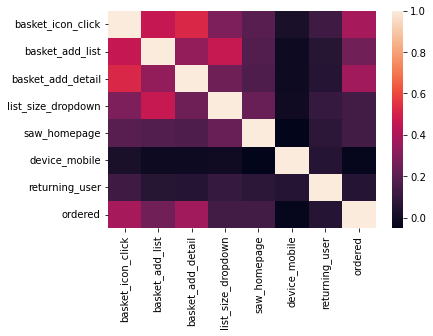

In [25]:
sns.heatmap(data.corr())

In [26]:
# Sprawdzanie niezbilansowania bazy
round((data[data == 1].count()/len(data))*100,2)

basket_icon_click      9.29
basket_add_list        7.11
basket_add_detail     10.61
list_size_dropdown    22.68
saw_homepage          28.89
device_mobile         68.09
returning_user        53.35
ordered                3.15
dtype: float64

In [27]:
# Oblicznie stosunku 0 do 1 - argument do xgb classifier żeby zrównoważyć dane

neg_samples = np.sum(y == 0)
pos_samples = np.sum(y == 1)
scale_pos_weight = neg_samples / pos_samples

In [28]:
# Modele na początek
lr = LogisticRegression(class_weight='balanced')
dt = DecisionTreeClassifier(class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced')
nb = GaussianNB() 
xgb_cl = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

In [29]:
# Lista modeli
models = [lr, dt, rf, nb, xgb_cl]

In [30]:
# Metryki
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']

Dla LogisticRegression: Accuracy: 0.894 | F1 Score: 0.647 | AUC Score: 0.945 | Precision: 0.607 | Recall: 0.898


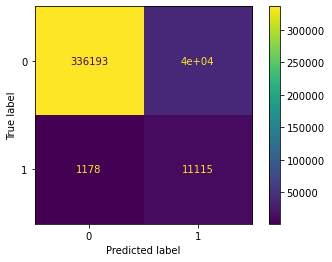

Dla DecisionTreeClassifier: Accuracy: 0.875 | F1 Score: 0.628 | AUC Score: 0.948 | Precision: 0.597 | Recall: 0.912


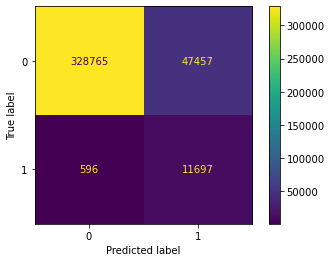

In [31]:
results = []

for model in models:
    # Trenowanie
    model.fit(X_train, y_train) 
    
    # Crossvalidation
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10)
    
    # Wyciąganie metryk
    accuracy = round(np.mean(scores['test_accuracy']),3)
    f1 = round(np.mean(scores['test_f1_macro']),3)
    AUC = round(np.mean(scores['test_roc_auc']),3)
    precision = round(np.mean(scores['test_precision_macro']),3)
    recall = round(np.mean(scores['test_recall_macro']),3)
    
    # Macierz pomyłek
    y_pred = model.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    
    # Metryki do listy pod df
    results.append({
        'model': model.__class__.__name__,
        'auc': AUC,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })
    
    # Wydruk
    print('Dla {}: Accuracy: {} | F1 Score: {} | AUC Score: {} | Precision: {} | Recall: {}'.format(type(model).__name__, accuracy, f1, AUC, precision, recall))
    
    # Macierz pomyłek graficznie
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()  

In [ ]:
# Porównanie metryk powyższych modeli w df
results_df = pd.DataFrame.from_records(results) 
results_df

,model,auc,accuracy,f1,precision,recall
0,LogisticRegression,0.945,0.894,0.647,0.607,0.898
1,DecisionTreeClassifier,0.948,0.875,0.628,0.597,0.912
2,RandomForestClassifier,0.948,0.875,0.629,0.597,0.912
3,GaussianNB,0.935,0.908,0.644,0.605,0.827
4,XGBClassifier,0.949,0.875,0.628,0.597,0.912


Krzywa ROC dla LogisticRegression


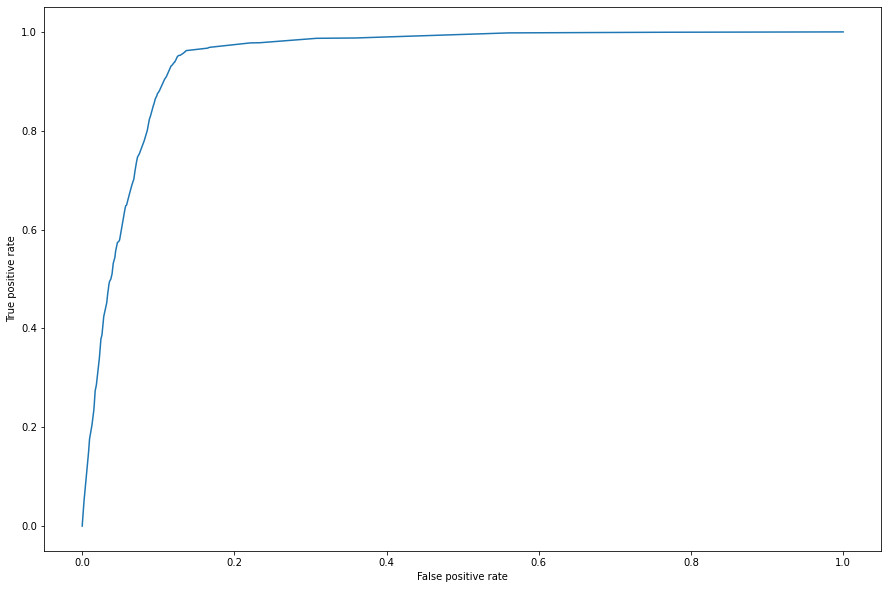

Krzywa ROC dla DecisionTreeClassifier


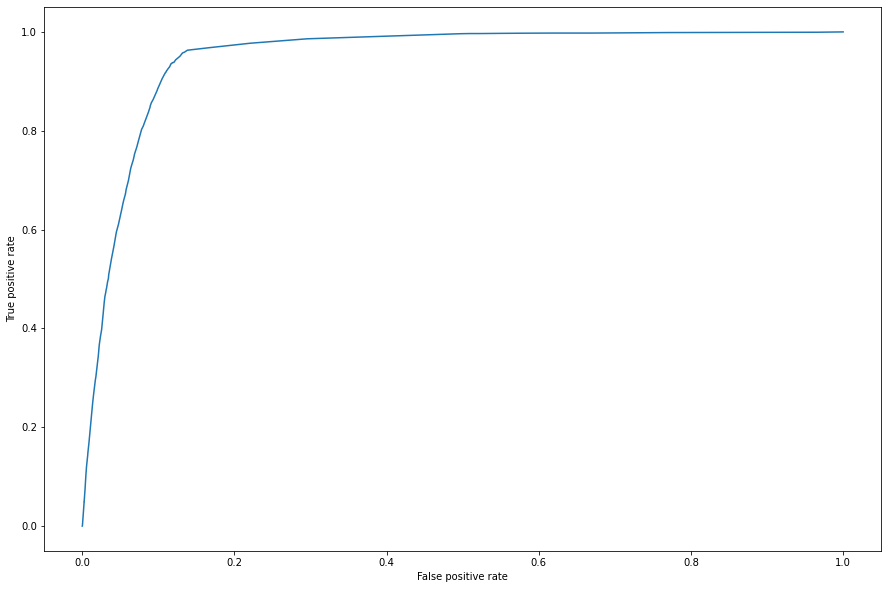

Krzywa ROC dla RandomForestClassifier


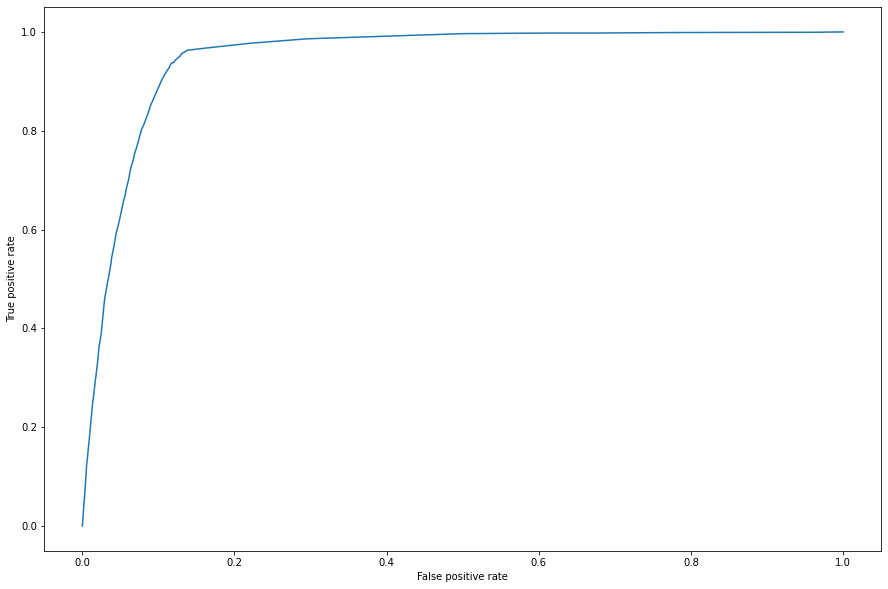

Krzywa ROC dla GaussianNB


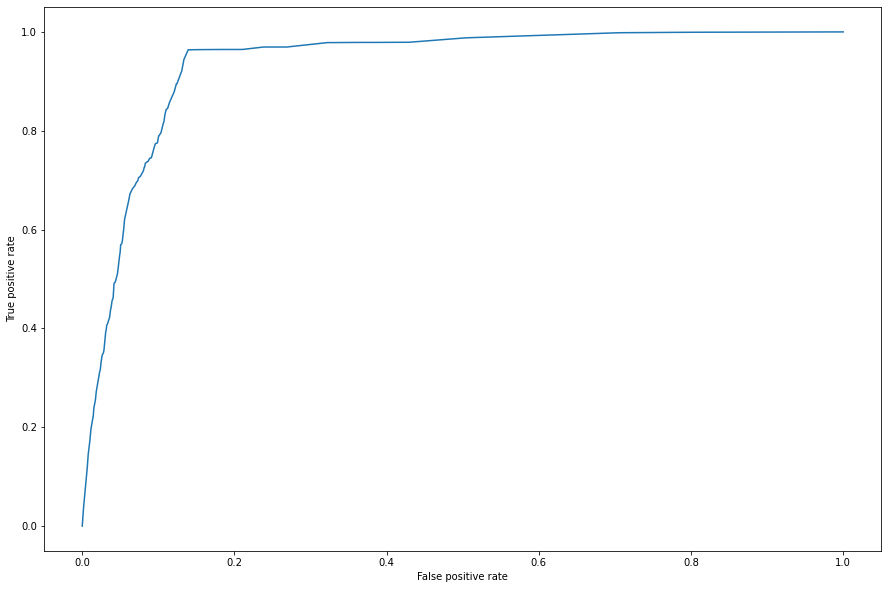

Krzywa ROC dla XGBClassifier


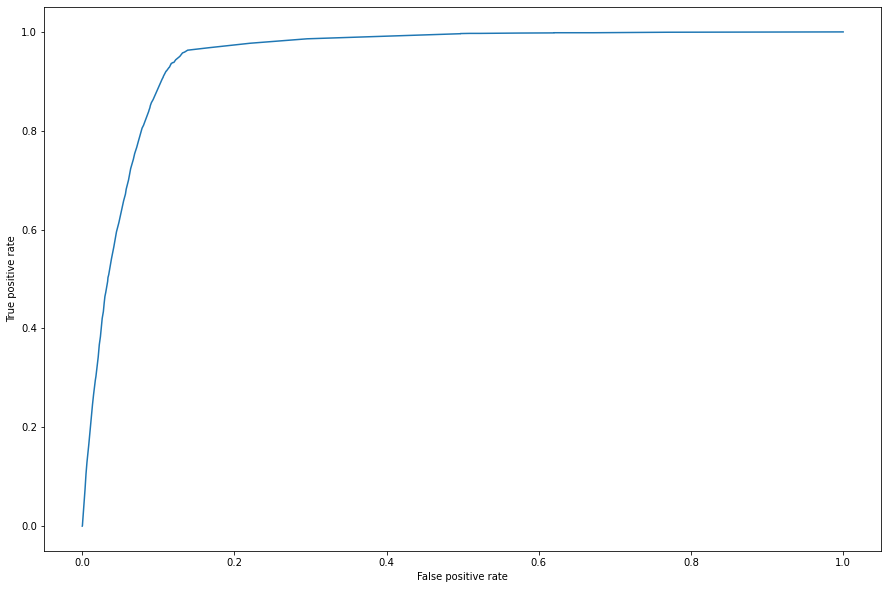

In [ ]:
# Krzywe ROC 
for model in models:
    probas = model.predict_proba(X_valid)
    positive_proba = probas[:, 1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, positive_proba)
    print('Krzywa ROC dla {}'.format(type(model).__name__))
    plt.figure(figsize=(15, 10))
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()
 

In [ ]:
results2 = []
for model in models:   
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_valid)[:, 1]
    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        y_pred_labels = np.where(y_pred > i, 1, 0)
        results2.append({
            "model": model.__class__.__name__,
            "threshold": i,
            "auc": round(roc_auc_score(y_valid, y_pred_labels),2),
            "accuracy": round(accuracy_score(y_valid, y_pred_labels),2),
            "f1": round(f1_score(y_valid, y_pred_labels),2),
            "recall": round(recall_score(y_valid, y_pred_labels),2),
            "precision": round(precision_score(y_valid, y_pred_labels),2)
            })


In [ ]:
results_df2 = pd.DataFrame.from_records(results2)

In [ ]:
results_df2.sort_values(by='precision', ascending=False)

,model,threshold,auc,accuracy,f1,recall,precision
44,XGBClassifier,0.9,0.75,0.95,0.39,0.54,0.31
17,DecisionTreeClassifier,0.9,0.75,0.95,0.39,0.54,0.31
26,RandomForestClassifier,0.9,0.76,0.95,0.39,0.56,0.31
8,LogisticRegression,0.9,0.76,0.94,0.38,0.57,0.28
7,LogisticRegression,0.8,0.80,0.93,0.37,0.65,0.26
35,GaussianNB,0.9,0.81,0.93,0.37,0.68,0.25
6,LogisticRegression,0.7,0.84,0.92,0.37,0.75,0.25
16,DecisionTreeClassifier,0.8,0.87,0.92,0.37,0.81,0.24
25,RandomForestClassifier,0.8,0.87,0.91,0.37,0.83,0.24
43,XGBClassifier,0.8,0.88,0.91,0.37,0.84,0.24


In [ ]:
feature_names = data.columns[:-1]
feature_names

Index(['basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'list_size_dropdown', 'saw_homepage', 'device_mobile',
       'returning_user'],
      dtype='object')

In [ ]:
def fimport(model):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_valid)
    importances = model.feature_importances_
    feature_importances = pd.Series(importances, index=feature_names)
    print(model.__class__.__name__)
    return feature_importances.nlargest(20).plot(kind='barh')

In [ ]:
feature_models = [dt, rf, xgb_cl]

DecisionTreeClassifier


<AxesSubplot:>

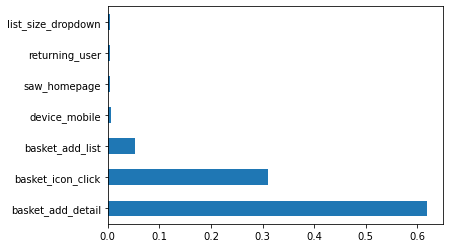

In [ ]:
fimport(dt)

RandomForestClassifier


<AxesSubplot:>

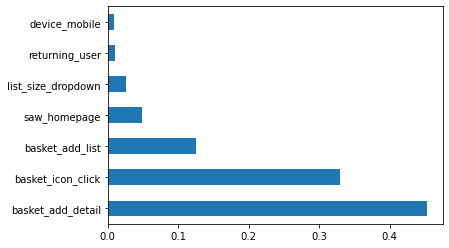

In [ ]:
fimport(rf)

XGBClassifier


<AxesSubplot:>

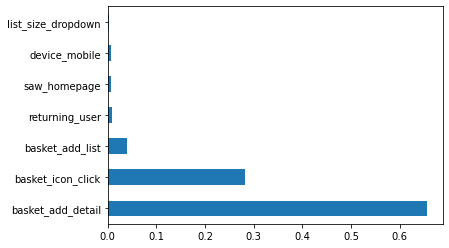

In [ ]:
fimport(xgb_cl)

In [ ]:
def objective_xgb(params):
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # ponieważ Hyperopt minimalizuje funkcję celu, a my chcemy maksymalizować accuracy


In [ ]:
space_xgb = {
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 200, 1))
}


In [ ]:
best_xgb = fmin(fn=objective_xgb,
                space=space_xgb,
                algo=tpe.suggest,
                max_evals=100)

100%|██████████| 100/100 [07:53<00:00,  4.73s/trial, best loss: -0.9687839752248543]


In [ ]:
print(best_xgb)

{'learning_rate': 0.17446636057214115, 'max_depth': 7, 'n_estimators': 125.0}


In [ ]:
# Ustawienia parametrów
params = {
    'learning_rate': 0.17446636057214115,
    'max_depth': 7,
    'n_estimators': 125
}

# Inicjalizacja modelu XGBoost z użyciem optymalnych parametrów
model = xgb.XGBClassifier(**params)

# Trenowanie modelu
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17446636057214115,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=125, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

c:\Users\48694\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\48694\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\48694\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\48694\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedM

Dla XGBClassifier: Accuracy: 0.968 | F1 Score: 0.493 | AUC Score: 0.949 | Precision: 0.54 | Recall: 0.5


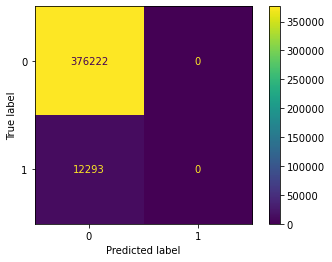

In [ ]:

    
# Crossvalidation
scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10)
    
# Wyciąganie metryk
accuracy = round(np.mean(scores['test_accuracy']),3)
f1 = round(np.mean(scores['test_f1_macro']),3)
AUC = round(np.mean(scores['test_roc_auc']),3)
precision = round(np.mean(scores['test_precision_macro']),3)
recall = round(np.mean(scores['test_recall_macro']),3)
    
# Macierz pomyłek
y_pred = model.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
    
# Metryki do listy pod df
results.append({
    'model': model.__class__.__name__,
    'auc': AUC,
    'accuracy': accuracy,
    'f1': f1,
    'precision': precision,
    'recall': recall
})
    
# Wydruk
print('Dla {}: Accuracy: {} | F1 Score: {} | AUC Score: {} | Precision: {} | Recall: {}'.format(type(model).__name__, accuracy, f1, AUC, precision, recall))
    
# Macierz pomyłek graficznie
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()  

In [ ]:


# Definiowanie 
def objective_xgb(params):
    # zmiana do int
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    # Inicjalizacja modelu XGBoost z użyciem przekazanych parametrów
    model = xgb.XGBClassifier(**params)
    
    # kroswalidacja
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    
    # Obliczanie średniej recall i precision
    recall = np.mean(scores)
    precision = np.mean(scores)
    
    # do optymalizacji
    return -0.5*(recall + precision)

# określenie przestrzeni
space_xgb = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1)
}

# Uruchamianie optymalizacji
best_xgb = fmin(fn=objective_xgb,
                space=space_xgb,
                algo=tpe.suggest,
                max_evals=100)


100%|██████████| 100/100 [2:45:53<00:00, 99.53s/trial, best loss: -0.9685482064308522]    


In [ ]:
print(best_xgb)

{'learning_rate': 0.007409894757218536, 'max_depth': 3, 'n_estimators': 138.0}


In [ ]:
params = {
    'learning_rate': 0.00740989,
    'max_depth': 3,
    'n_estimators': 138
}

# best_xgb
model = xgb.XGBClassifier(**params)


model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.00740989,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=138, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

c:\Users\48694\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\48694\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\48694\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\48694\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedM

Dla XGBClassifier: Accuracy: 0.968 | F1 Score: 0.492 | AUC Score: 0.937 | Precision: 0.484 | Recall: 0.5


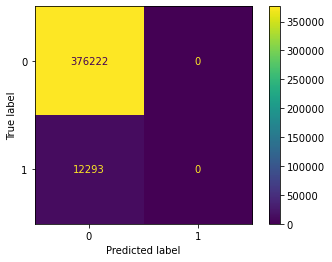

In [ ]:

    
# Wyciąganie metryk
accuracy = round(np.mean(scores['test_accuracy']),3)
f1 = round(np.mean(scores['test_f1_macro']),3)
AUC = round(np.mean(scores['test_roc_auc']),3)
precision = round(np.mean(scores['test_precision_macro']),3)
recall = round(np.mean(scores['test_recall_macro']),3)
    
# Macierz pomyłek
y_pred = model.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
    
# Metryki do listy pod df
results.append({
    'model': model.__class__.__name__,
    'auc': AUC,
    'accuracy': accuracy,
    'f1': f1,
    'precision': precision,
    'recall': recall
})
    
# Wydruk
print('Dla {}: Accuracy: {} | F1 Score: {} | AUC Score: {} | Precision: {} | Recall: {}'.format(type(model).__name__, accuracy, f1, AUC, precision, recall))
    
# Macierz pomyłek graficznie
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()  